**Training a SVM Classifier Model to Detect Offensive Tweets**

This script uses the training data prepared in the first script and trains an SVM model using three features: tweet itself (lemma form), emotions in tweet and insults in tweet. 

The features in this model as well as hyperparameter tuning follow the work of Markov and Daelemans (2021) who also used emotion and hate speech lexicons as features and SVM to classify offensive text.

In [1]:
# mounting to drive to use colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# import packages, download nltk punkt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk
nltk.download('punkt')

# pipeline, scaling, preprocessing, modelling, train-test split, model selection and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import learning_curve, cross_val_score

# load nltk TweetTokenizer to use as tokenizer of tweets
from nltk.tokenize import TweetTokenizer

# load word tokenizer for the other text columns
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
data_path = 'drive/MyDrive/NLP_Final_Assignment/data/df_preprocessed.csv'

df = pd.read_csv(data_path, sep=',', header=0)

In [24]:
df.head()
df = df.set_index('id')
df.head()

,tweet,offensive,tweet_clean,tweet_lemmas,tweet_pos,tweet_emotions,insult_match
id,,,,,,,
86426,@USER She should ask a few native Americans wh...,1,@user she should ask a few native americans wh...,@user -PRON- should ask a few native americans...,X PRON VERB VERB DET ADJ ADJ PROPN PRON DET VE...,NaN,NaN
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,@user @user go home you are drunk! @user maga ...,@user @user go home -PRON- be drunk ! @user ma...,X PUNCT VERB ADV PRON AUX ADJ PUNCT X PROPN PR...,NaN,NaN
16820,Amazon is investigating Chinese employees who ...,0,amazon is investigating chinese employees who ...,amazon be investigate chinese employee who be ...,PROPN AUX VERB ADJ NOUN PRON AUX VERB ADJ NOUN...,NaN,NaN
62688,"@USER Someone should'veTaken"" this piece of sh...",1,@user someone shouldvetaken this piece of shit...,@user someone shouldvetaken this piece of shit...,PUNCT PRON VERB DET NOUN ADP NOUN ADP DET NOUN...,anger disgust negative fear surprise,shit
43605,@USER @USER Obama wanted liberals &amp; illega...,0,@user @user obama wanted liberals amp; illegal...,@user @user obama want liberal amp ; illegal t...,PUNCT PUNCT PROPN VERB NOUN VERB PUNCT NOUN PA...,NaN,NaN


In [25]:
df = df.fillna('')
df.isnull().sum()

tweet             0
offensive         0
tweet_clean       0
tweet_lemmas      0
tweet_pos         0
tweet_emotions    0
insult_match      0
dtype: int64

In [26]:
df.offensive.value_counts()

0    8817
1    4395
Name: offensive, dtype: int64

In [27]:
df.head()

,tweet,offensive,tweet_clean,tweet_lemmas,tweet_pos,tweet_emotions,insult_match
id,,,,,,,
86426,@USER She should ask a few native Americans wh...,1,@user she should ask a few native americans wh...,@user -PRON- should ask a few native americans...,X PRON VERB VERB DET ADJ ADJ PROPN PRON DET VE...,,
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,@user @user go home you are drunk! @user maga ...,@user @user go home -PRON- be drunk ! @user ma...,X PUNCT VERB ADV PRON AUX ADJ PUNCT X PROPN PR...,,
16820,Amazon is investigating Chinese employees who ...,0,amazon is investigating chinese employees who ...,amazon be investigate chinese employee who be ...,PROPN AUX VERB ADJ NOUN PRON AUX VERB ADJ NOUN...,,
62688,"@USER Someone should'veTaken"" this piece of sh...",1,@user someone shouldvetaken this piece of shit...,@user someone shouldvetaken this piece of shit...,PUNCT PRON VERB DET NOUN ADP NOUN ADP DET NOUN...,anger disgust negative fear surprise,shit
43605,@USER @USER Obama wanted liberals &amp; illega...,0,@user @user obama wanted liberals amp; illegal...,@user @user obama want liberal amp ; illegal t...,PUNCT PUNCT PROPN VERB NOUN VERB PUNCT NOUN PA...,,


**Modelled variables**

The features that are added: tweet lemmas, emotions, pos-tags and abusive words lexicon. 

In [28]:
X = df[['tweet_lemmas', 'tweet_emotions','insult_match', 'tweet_pos']]
y = df['offensive']
X.shape, type(X)

((13212, 4), pandas.core.frame.DataFrame)

In [29]:
y.shape, type(y)

((13212,), pandas.core.series.Series)

In [30]:
# Split dataset into train and development sets
X_train, X_dev, y_train, y_dev = train_test_split(X,y, test_size=0.1,random_state=42, stratify=y, shuffle=True) # 90% training and 10% development

print(X_train.shape)
print(X_dev.shape)
print(y_train.shape)
print(y_dev.shape)



(11890, 4)
(1322, 4)
(11890,)
(1322,)


In [31]:
# changing types to be able to use tfidf vectorizer
df['tweet_lemmas'] = df['tweet_lemmas'].values.astype('U')
df['tweet_emotions'] = df['tweet_emotions'].values.astype('U')
df['insult_match'] = df['insult_match'].values.astype('U')
df['tweet_pos'] = df['tweet_pos'].values.astype('U')

In [32]:
df['insult_match'].value_counts()

                                         12054
shit                                       327
stupid                                      91
idiot                                       44
dumb                                        35
                                         ...  
shit foolish                                 1
asshole shit                                 1
ignorant fool ignorant ignorant idiot        1
idiot retard                                 1
midget                                       1
Name: insult_match, Length: 168, dtype: int64

In [33]:
df['tweet_emotions'].value_counts()

                                                                                2676
positive                                                                         458
negative                                                                         344
anger fear negative                                                              283
positive trust                                                                   273
                                                                                ... 
surprise fear anger anticipation joy negative positive sadness trust               1
anger fear negative surprise anticipation disgust joy positive trust sadness       1
anger fear negative anticipation joy positive disgust sadness trust                1
positive negative anger disgust fear trust                                         1
fear negative positive trust sadness                                               1
Name: tweet_emotions, Length: 3323, dtype: int64

In [34]:
vectorizer = TfidfVectorizer()
count_vector=vectorizer.fit_transform(df['tweet_emotions'])
vectorizer.vocabulary_

{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'negative': 5,
 'positive': 6,
 'sadness': 7,
 'surprise': 8,
 'trust': 9}

In [35]:
count_vector=vectorizer.fit_transform(df['insult_match'])
vectorizer.vocabulary_.keys()

dict_keys(['shit', 'nonsense', 'prisoners', 'dumb', 'fool', 'animals', 'ugly', 'dumbass', 'brainless', 'idiots', 'vile', 'simple', 'idiotic', 'brutality', 'trash', 'mark', 'stupid', 'putz', 'ugliness', 'silly', 'assholes', 'lump', 'dimwit', 'idiot', 'insane', 'moron', 'retard', 'halt', 'nitwit', 'despicable', 'craziness', 'dull', 'animal', 'ignorant', 'beast', 'prick', 'dim', 'uncultured', 'motherfucker', 'green', 'worthless', 'mob', 'childish', 'dope', 'dupe', 'bastard', 'stupidity', 'rat', 'twat', 'asshole', 'foolish', 'mug', 'bum', 'slow', 'creature', 'rats', 'retarded', 'illiterate', 'sucker', 'sob', 'unable', 'wretched', 'incompetent', 'cuckoo', 'fooled', 'gullible', 'cripple', 'lame', 'juvenile', 'incapable', 'mother', 'fucker', 'ahole', 'dummy', 'quack', 'twit', 'folly', 'slimy', 'rubbish', 'poop', 'witless', 'brutal', 'rabble', 'chatterbox', 'imbecile', 'telltale', 'goofball', 'wolf', 'savage', 'boob', 'dense', 'foolishness', 'midget', 'dwarf', 'shithead', 'dolt', 'quackery', '

**Modelling**

Performing a Grid Search with 5 fold cross validation. The pipeline prepares the input text features using TfIdfVectorizer and different tokenizer for tweets. Tweet Tokenizer takes some features belonging to tweets together while word tokenizer splits them, for instance an emoticon would be tokenized together as emoticon (though the special characters are removed in the previous step so this will no longer be possible) rather than different special characters and @user will be tokenized as @user instead of '@' and 'user'. 

In [36]:
# create a function for the tweet tokenizer from NLTK
def tokenizer_tweets(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

# create a function for the word tokenizer from NLTK
def tokenizer_rest(text):
  return word_tokenize(text)

In [ ]:
# preparing pipeline 

clf = SGDClassifier(random_state=42)
vect = TfidfVectorizer(min_df = 10) #including by default only n-grams occuring
# at least in ten tweets of the training set


tweet_preprocessing = Pipeline([('vect', TfidfVectorizer(analyzer = 'word', tokenizer = tokenizer_tweets))])
extra_preprocessing = Pipeline([('vect', TfidfVectorizer(tokenizer = tokenizer_rest))])

extra_text_features = X.drop(['tweet_lemmas'],axis=1).select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(transformers = [
                            ('tweet_preprocessing', tweet_preprocessing, 'tweet_lemmas'),
                            ('extra_preprocessing', extra_preprocessing, 'tweet_emotions'),
                            ('extra_preprocessing2', extra_preprocessing, 'insult_match'),
                            ('extra_preprocessing3', extra_preprocessing, 'tweet_pos')
                        ]) 



pipeline = Pipeline([
                ('preprocess', preprocess),
                ('clf', clf)
            ])

In [ ]:
pipeline.named_steps

{'clf': SGDClassifier(random_state=42),
 'preprocess': ColumnTransformer(transformers=[('tweet_preprocessing',
                                  Pipeline(steps=[('vect',
                                                   TfidfVectorizer(tokenizer=<function tokenizer_tweets at 0x7f7a285d5680>))]),
                                  'tweet_lemmas'),
                                 ('extra_preprocessing',
                                  Pipeline(steps=[('vect',
                                                   TfidfVectorizer(tokenizer=<function tokenizer_rest at 0x7f7a285d53b0>))]),
                                  'tweet_emotions'),
                                 ('extra_preprocessing2',
                                  Pipeline(steps=[('vect',
                                                   TfidfVectorizer(tokenizer=<function tokenizer_rest at 0x7f7a285d53b0>))]),
                                  'insult_match'),
                                 ('extra_preprocessing3',
    

In [ ]:
parameters = [{
    #unigrams and bigrams for tweets
    'preprocess__tweet_preprocessing__vect__ngram_range': [(1,1),(1,2)], 
    #ignore terms that appear in more than 50%, 70%, 90% of the documents or 
    #100% (default-no term is ignored) 
    'preprocess__tweet_preprocessing__vect__max_df': [0.50, 0.70, 0.90, 1.0], 
    # get words for emotions 
    'preprocess__extra_preprocessing__vect__analyzer': ['word'], 
     #unigrams and bigrams for emotions
    'preprocess__extra_preprocessing__vect__ngram_range': [(1,1),(1,2)],
    # get char for insults
    'preprocess__extra_preprocessing2__vect__analyzer': ['char'], 
    'preprocess__extra_preprocessing2__vect__ngram_range': [(1,6), (2,6), (3,6)],
    'preprocess__extra_preprocessing3__vect__analyzer': ['word'], 
     #unigrams for POS
    'preprocess__extra_preprocessing__vect__ngram_range': [(1,1)],
    # trying svm and logistic regression
    'clf__loss': ['hinge', 'log'], 
    'clf__penalty' : ["l2", "l1"],
    'clf__tol' : [0.0005, 0.001, 0.005, 0.01]
    }]

In [ ]:
gs = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, refit=True, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('tweet_preprocessing',
                                                                         Pipeline(steps=[('vect',
                                                                                          TfidfVectorizer(tokenizer=<function tokenizer_tweets at 0x7f7a285d5680>))]),
                                                                         'tweet_lemmas'),
                                                                        ('extra_preprocessing',
                                                                         Pipeline(steps=[('vect',
                                                                                          TfidfVectorizer(tokenizer=<function tokenizer_rest at 0x7f7a285d53b0>))]),
                                                                         'tweet...
                                  

In [ ]:
clf.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
gs.best_score_

0.7809924306139613

In [ ]:
gs.best_params_

{'clf__loss': 'hinge',
 'clf__penalty': 'l1',
 'clf__tol': 0.005,
 'preprocess__extra_preprocessing2__vect__analyzer': 'char',
 'preprocess__extra_preprocessing2__vect__ngram_range': (3, 6),
 'preprocess__extra_preprocessing3__vect__analyzer': 'word',
 'preprocess__extra_preprocessing__vect__analyzer': 'word',
 'preprocess__extra_preprocessing__vect__ngram_range': (1, 1),
 'preprocess__tweet_preprocessing__vect__max_df': 1.0,
 'preprocess__tweet_preprocessing__vect__ngram_range': (1, 1)}

**Running best pipeline for predictions**

In [37]:
tweet_preprocessing = Pipeline([('vect', TfidfVectorizer(analyzer = 'word', tokenizer = tokenizer_tweets, ngram_range = (1,1), max_df = 1.0))])
extra_preprocessing = Pipeline([('vect', TfidfVectorizer(analyzer = 'word', tokenizer = tokenizer_rest, ngram_range = (1,2)))])
extra_preprocessing2 = Pipeline([('vect', TfidfVectorizer(analyzer = 'char', tokenizer = tokenizer_rest, ngram_range = (2,6)))])
extra_preprocessing3 = Pipeline([('vect', TfidfVectorizer(analyzer = 'word', tokenizer = tokenizer_rest, ngram_range = (1,1)))])


preprocess = ColumnTransformer(transformers = [
                            ('tweet_preprocessing', tweet_preprocessing, 'tweet_lemmas'),
                            ('extra_preprocessing', extra_preprocessing, 'tweet_emotions'),
                            ('extra_preprocessing2', extra_preprocessing2, 'insult_match'), 
                            ('extra_preprocessing3', extra_preprocessing2, 'tweet_pos'),
                        ]) 

best_pipe = Pipeline([
                ('preprocess', preprocess),
                ('clf', SGDClassifier(random_state=42, loss = 'hinge', penalty = "l1", tol = 0.005))
            ])

In [41]:
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tweet_preprocessing',
                                                  Pipeline(steps=[('vect',
                                                                   TfidfVectorizer(tokenizer=<function tokenizer_tweets at 0x7fe28a21f560>))]),
                                                  'tweet_lemmas'),
                                                 ('extra_preprocessing',
                                                  Pipeline(steps=[('vect',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2),
                                                                                   tokenizer=<function tokenizer_rest at 0x7fe28a21f3b0>))]),
                                                  'tweet_emotions'...
                                                   

In [42]:
y_pred = best_pipe.predict(X_dev)
print(classification_report(y_dev, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.795     0.932     0.858       882
           1      0.792     0.518     0.626       440

    accuracy                          0.794      1322
   macro avg      0.793     0.725     0.742      1322
weighted avg      0.794     0.794     0.781      1322



In [43]:
best_pipe.score(X_dev, y_dev) #accuracy

0.794251134644478

**Error Analysis**

*Cross-validation*

Applying 5-fold cross validation where the training set is split into 5 sets and for each iteration model is trained with 4 sets and tested on the 5th set. Model f-1 score (macro averaged) is stable across models, averaging on 0.72 with a standard deviation of 0.01. 

In [44]:
# Evaluate the model using cross-validation

scores = cross_val_score(best_pipe, X_train, y_train, scoring='f1_macro', cv=5)
scores

array([0.74389952, 0.72888922, 0.70099253, 0.71526876, 0.7304966 ])

In [45]:
print("%0.3f f1-score with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.72 f1-score with a standard deviation of 0.015


*Learning Curve*

Learning curve is plotted to see the training scores of each iteration of the 5-fold cross validation against the cross-validation score (Score refers to macro averaged f1 scores of the models).

In [46]:
train_sizes, train_scores, test_scores = learning_curve(estimator=best_pipe, X=X_train, y=y_train, scoring='f1_macro', cv=5)

In [47]:
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean, train_std, test_mean, test_std)

[0.9988288  0.93465555 0.85140121 0.79391889 0.77254446] [0.00234241 0.00406991 0.0081484  0.00588954 0.00717419] [0.6507594  0.68982829 0.7099896  0.72019976 0.72390933] [0.00502807 0.00828423 0.01012536 0.01493108 0.01461259]


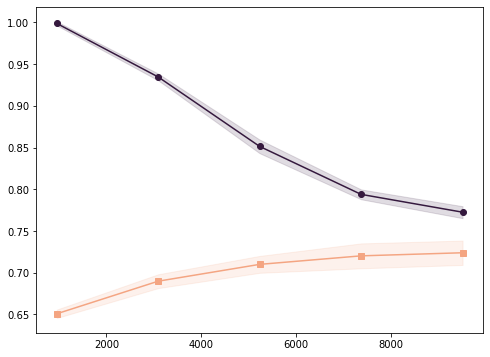

In [48]:
fig = plt.figure(figsize=(8,6));
plt.plot(train_sizes, train_mean, color='#35193e', marker='o', label="Training score")
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='#35193e')
plt.plot(train_sizes, test_mean, color='#F4A582', marker='s', label="Cross-validation score")
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='#F4A582')
plt.show()

The learning curve shows a generalizable model without over- or underfitting problem. The model learns more after the first increase in the training data and it stabilizes after a while around 0.76. The cross validation score increases as training size increases and comes close to the training accuracy, it could be further increased with more training data.

**Predictions with test data sets - updated to labeled sets after scoreboard**

In [ ]:
# get all preprocessed test datasets

# test_in_preprocessed_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_IN_preprocessed.csv'
# test_out1_preprocessed_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT1_preprocessed.csv'
# test_out2_preprocessed_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT2_preprocessed.csv'
# test_textgain_preprocessed_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_TEXTGAIN_preprocessed.csv'

# test_in = pd.read_csv(test_in_preprocessed_path, sep=',', header=0)
# test_out1 = pd.read_csv(test_out1_preprocessed_path, sep=',', header=0)
# test_out2 = pd.read_csv(test_out2_preprocessed_path, sep=',', header=0)
# test_textgain = pd.read_csv(test_textgain_preprocessed_path, sep=',', header=0)

In [49]:
test_in_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_IN_labels.csv'
test_out1_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT1_labels.csv'
test_out2_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT2_labels.csv'
test_textgain_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_TEXTGAIN_labels.csv'

test_in = pd.read_csv(test_in_labels_path, sep=',', header=0)
test_out1 = pd.read_csv(test_out1_labels_path, sep=',', header=0)
test_out2 = pd.read_csv(test_out2_labels_path, sep=',', header=0)
test_textgain = pd.read_csv(test_textgain_labels_path, sep=',', header=0)

In [50]:
test_in = test_in.set_index('id')
test_in = test_in.fillna('')

test_out1 = test_out1.set_index('id')
test_out1 = test_out1.fillna('')

test_out2 = test_out2.set_index('id')
test_out2 = test_out2.fillna('')

test_textgain = test_textgain.set_index('id')
test_textgain = test_textgain.fillna('')

In [51]:
# changing types to be able to use tfidf vectorizer
dataframes = [test_in, test_out1, test_out2, test_textgain]
for df in dataframes:
  df['tweet_lemmas'] = df['tweet_lemmas'].values.astype('U')
  df['tweet_emotions'] = df['tweet_emotions'].values.astype('U')
  df['insult_match'] = df['insult_match'].values.astype('U')
  df['tweet_pos'] = df['tweet_pos'].values.astype('U')

**In-domain Twitter Data**

In [52]:
X_test_in = test_in[['tweet_lemmas', 'tweet_emotions','insult_match', 'tweet_pos']]

In [53]:
X_test_in.head()

,tweet_lemmas,tweet_emotions,insult_match,tweet_pos
id,,,,
15923,whoisq wherestheserver dumpnike declasfisa dem...,positive trust anticipation joy disgust fear n...,,AUX VERB ADJ NOUN PROPN VERB PROPN PUNCT PROPN...
27014,"constitutionday be revere by conservative , ha...",fear,,PROPN AUX VERB ADP NOUN PUNCT VERB ADP NOUN PR...
30530,foxnew nra maga potus trump 2ndamendment rnc u...,surprise,,NOUN VERB NOUN NOUN NOUN NUM NOUN NOUN NOUN PR...
13876,watch boomer get the news that she be still up...,anticipation joy positive surprise trust,,VERB NOUN VERB DET NOUN SCONJ PRON AUX ADV ADV...
60133,nopasaran : unity demo to oppose the farright ...,positive trust negative,,ADV PUNCT NOUN NOUN PART VERB DET NOUN ADP PRO...


In [54]:
X_test_in.shape

(860, 4)

In [55]:
y_test_in = test_in.offensive
y_test_in.shape

(860,)

In [56]:
y_pred_test_in = best_pipe.predict(X_test_in)
print(classification_report(y_test_in, y_pred_test_in, digits=3))

              precision    recall  f1-score   support

           0      0.827     0.948     0.884       620
           1      0.785     0.487     0.602       240

    accuracy                          0.820       860
   macro avg      0.806     0.718     0.743       860
weighted avg      0.815     0.820     0.805       860



In [57]:
y_pred_test_in = best_pipe.predict(X_test_in)
y_pred_test_in  = pd.DataFrame(y_pred_test_in)
X_test_in = X_test_in.reset_index()
X_test_in['y_pred_test_in'] = y_pred_test_in

In [58]:
print(X_test_in.shape)
X_test_in.head()

(860, 6)


,id,tweet_lemmas,tweet_emotions,insult_match,tweet_pos,y_pred_test_in
0,15923,whoisq wherestheserver dumpnike declasfisa dem...,positive trust anticipation joy disgust fear n...,,AUX VERB ADJ NOUN PROPN VERB PROPN PUNCT PROPN...,1
1,27014,"constitutionday be revere by conservative , ha...",fear,,PROPN AUX VERB ADP NOUN PUNCT VERB ADP NOUN PR...,0
2,30530,foxnew nra maga potus trump 2ndamendment rnc u...,surprise,,NOUN VERB NOUN NOUN NOUN NUM NOUN NOUN NOUN PR...,0
3,13876,watch boomer get the news that she be still up...,anticipation joy positive surprise trust,,VERB NOUN VERB DET NOUN SCONJ PRON AUX ADV ADV...,0
4,60133,nopasaran : unity demo to oppose the farright ...,positive trust negative,,ADV PUNCT NOUN NOUN PART VERB DET NOUN ADP PRO...,0


In [59]:
test_in_traditional = X_test_in[X_test_in[['id', 'y_pred_test_in']].notnull()].copy()
test_in_traditional = test_in_traditional[['id', 'y_pred_test_in']]
test_in_traditional['y_pred_test_in'] = test_in_traditional['y_pred_test_in'].map({1: 'OFF', 0: 'NOT'})
test_in_traditional.rename({'y_pred_test_in': 'label'}, axis=1, inplace=True)
test_in_traditional.head()

,id,label
0,15923,OFF
1,27014,NOT
2,30530,NOT
3,13876,NOT
4,60133,NOT


In [60]:
test_in_traditional.label.value_counts()

NOT    711
OFF    149
Name: label, dtype: int64

In [61]:
# write out predictions
test_in_traditional_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_in_traditional_final.csv'
test_in_traditional.to_csv(test_in_traditional_path, encoding='utf-8', index=False)

**Out-domain Data 1 - Reddit**

In [62]:
X_test_out1 = test_out1[['tweet_lemmas', 'tweet_emotions','insult_match', 'tweet_pos']]

In [63]:
X_test_out1.head()

,tweet_lemmas,tweet_emotions,insult_match,tweet_pos
id,,,,
37,maybe it could have something to do with the r...,positive anger anticipation disgust fear joy n...,,ADV PRON AUX VERB PRON PART VERB ADP DET ADJ N...
127,"weirdly enough , I think about this fairly fre...",positive trust negative surprise anger fear,animal,ADV ADV PUNCT PRON VERB ADP PRON ADV ADV PUNCT...
143,your idea while pose a real problem with ethic...,positive trust fear negative sadness joy,,PRON NOUN SCONJ VERB DET ADJ NOUN ADP NOUN AUX...
146,it will encourage a part of the people you ban...,joy positive trust negative anticipation anger...,,PRON AUX VERB DET NOUN ADP DET NOUN PRON VERB ...
186,if something like this could make someone supp...,anger disgust fear negative sadness,barbaric,SCONJ PRON ADP PRON AUX VERB PRON NOUN NOUN PU...


In [64]:
X_test_out1.shape

(1207, 4)

In [89]:
y_test_out1 = test_out1.offensive
print(y_test_out1.shape)

y_pred_test_out1 = best_pipe.predict(X_test_out1)
print(classification_report(y_test_out1, y_pred_test_out1, digits=3))

(1207,)
              precision    recall  f1-score   support

           0      0.672     0.875     0.760       664
           1      0.757     0.477     0.585       543

    accuracy                          0.696      1207
   macro avg      0.714     0.676     0.673      1207
weighted avg      0.710     0.696     0.681      1207



In [66]:
y_pred_test_out1 = best_pipe.predict(X_test_out1)
y_pred_test_out1  = pd.DataFrame(y_pred_test_out1)
X_test_out1 = X_test_out1.reset_index()
X_test_out1['y_pred_test_out1'] = y_pred_test_out1

In [67]:
print(X_test_out1.shape)
X_test_out1.head()

(1207, 6)


,id,tweet_lemmas,tweet_emotions,insult_match,tweet_pos,y_pred_test_out1
0,37,maybe it could have something to do with the r...,positive anger anticipation disgust fear joy n...,,ADV PRON AUX VERB PRON PART VERB ADP DET ADJ N...,0
1,127,"weirdly enough , I think about this fairly fre...",positive trust negative surprise anger fear,animal,ADV ADV PUNCT PRON VERB ADP PRON ADV ADV PUNCT...,1
2,143,your idea while pose a real problem with ethic...,positive trust fear negative sadness joy,,PRON NOUN SCONJ VERB DET ADJ NOUN ADP NOUN AUX...,0
3,146,it will encourage a part of the people you ban...,joy positive trust negative anticipation anger...,,PRON AUX VERB DET NOUN ADP DET NOUN PRON VERB ...,1
4,186,if something like this could make someone supp...,anger disgust fear negative sadness,barbaric,SCONJ PRON ADP PRON AUX VERB PRON NOUN NOUN PU...,0


In [68]:
test_out1_traditional = X_test_out1[X_test_out1[['id', 'y_pred_test_out1']].notnull()].copy()
test_out1_traditional = test_out1_traditional[['id', 'y_pred_test_out1']]
test_out1_traditional['y_pred_test_out1'] = test_out1_traditional['y_pred_test_out1'].map({1: 'OFF', 0: 'NOT'})
test_out1_traditional.rename({'y_pred_test_out1': 'label'}, axis=1, inplace=True)
test_out1_traditional.head()

,id,label
0,37,NOT
1,127,OFF
2,143,NOT
3,146,OFF
4,186,NOT


In [69]:
test_out1_traditional.label.value_counts()

NOT    865
OFF    342
Name: label, dtype: int64

In [70]:
# write out predictions
test_out1_traditional_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_out1_traditional_final.csv'
test_out1_traditional.to_csv(test_out1_traditional_path, encoding='utf-8', index=False)

**Out-domain Data 2 - Wikipedia**

In [71]:
X_test_out2 = test_out2[['tweet_lemmas', 'tweet_emotions','insult_match', 'tweet_pos']]

In [72]:
X_test_out2.head()

,tweet_lemmas,tweet_emotions,insult_match,tweet_pos
id,,,,
0072b9c3697ab8cc,argh some random idiot delete the whole japan ...,disgust negative,idiot,PROPN DET ADJ NOUN VERB DET ADJ PROPN NOUN PUNCT
0081b14d79f54b31,we hate america and we be go to bomb the shit ...,anger disgust fear negative sadness surprise,shit,PRON VERB PROPN CCONJ PRON AUX VERB PART VERB ...
008eb47c4684d190,"so , on the tenth anniversary of 911 , new yor...",anger disgust fear negative anticipation posit...,,ADV PUNCT ADP DET ADJ NOUN ADP NUM PUNCT PROPN...
010c2a979fab2e3f,casualt I fuck your mum and I like it ! ie,fear negative,,PROPN PRON VERB PRON NOUN CCONJ PRON VERB PRON...
01680b05bde74236,"welcome ! hello , , and welcome to wikipedia !...",anticipation joy positive surprise trust,,INTJ PUNCT INTJ PUNCT PUNCT CCONJ VERB ADP NOU...


In [73]:
X_test_out2.shape

(1200, 4)

In [74]:
y_test_out2 = test_out2.offensive
print(y_test_out2.shape)

y_pred_test_out2 = best_pipe.predict(X_test_out2)
print(classification_report(y_test_out2, y_pred_test_out2, digits=3))

(1200,)
              precision    recall  f1-score   support

           0      0.843     0.892     0.866       600
           1      0.885     0.833     0.858       600

    accuracy                          0.863      1200
   macro avg      0.864     0.863     0.862      1200
weighted avg      0.864     0.863     0.862      1200



In [75]:
y_pred_test_out2 = best_pipe.predict(X_test_out2)
y_pred_test_out2  = pd.DataFrame(y_pred_test_out2)
X_test_out2 = X_test_out2.reset_index()
X_test_out2['y_pred_test_out2'] = y_pred_test_out2

In [76]:
print(X_test_out2.shape)
X_test_out2.head()

(1200, 6)


,id,tweet_lemmas,tweet_emotions,insult_match,tweet_pos,y_pred_test_out2
0,0072b9c3697ab8cc,argh some random idiot delete the whole japan ...,disgust negative,idiot,PROPN DET ADJ NOUN VERB DET ADJ PROPN NOUN PUNCT,1
1,0081b14d79f54b31,we hate america and we be go to bomb the shit ...,anger disgust fear negative sadness surprise,shit,PRON VERB PROPN CCONJ PRON AUX VERB PART VERB ...,1
2,008eb47c4684d190,"so , on the tenth anniversary of 911 , new yor...",anger disgust fear negative anticipation posit...,,ADV PUNCT ADP DET ADJ NOUN ADP NUM PUNCT PROPN...,1
3,010c2a979fab2e3f,casualt I fuck your mum and I like it ! ie,fear negative,,PROPN PRON VERB PRON NOUN CCONJ PRON VERB PRON...,1
4,01680b05bde74236,"welcome ! hello , , and welcome to wikipedia !...",anticipation joy positive surprise trust,,INTJ PUNCT INTJ PUNCT PUNCT CCONJ VERB ADP NOU...,0


In [77]:
test_out2_traditional = X_test_out2[X_test_out2[['id', 'y_pred_test_out2']].notnull()].copy()
test_out2_traditional = test_out2_traditional[['id', 'y_pred_test_out2']]
test_out2_traditional['y_pred_test_out2'] = test_out2_traditional['y_pred_test_out2'].map({1: 'OFF', 0: 'NOT'})
test_out2_traditional.rename({'y_pred_test_out2': 'label'}, axis=1, inplace=True)
test_out2_traditional.head()

,id,label
0,0072b9c3697ab8cc,OFF
1,0081b14d79f54b31,OFF
2,008eb47c4684d190,OFF
3,010c2a979fab2e3f,OFF
4,01680b05bde74236,NOT


In [78]:
test_out2_traditional.label.value_counts()

NOT    635
OFF    565
Name: label, dtype: int64

In [79]:
# write out predictions
test_out2_traditional_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_out2_traditional_final.csv'
test_out2_traditional.to_csv(test_out2_traditional_path, encoding='utf-8', index=False)


**TextGain Test Data**

In [80]:
X_test_textgain = test_textgain[['tweet_lemmas', 'tweet_emotions','insult_match', 'tweet_pos']]

In [81]:
X_test_textgain.head()

,tweet_lemmas,tweet_emotions,insult_match,tweet_pos
id,,,,
0,"a few american personality camel , well adjust...",positive,,DET ADJ ADJ NOUN NOUN PUNCT ADV VERB ADP NOUN ...
1,@user how come lukaku flop @ man uu .de nigg d...,disgust negative sadness,,INTJ SCONJ VERB NOUN NOUN ADP PROPN PROPN NUM ...
2,lukaku be such a nigger I hate this ape,negative anger disgust fear sadness,,NOUN AUX DET DET ADJ PRON VERB DET NOUN
3,I beg you lot keep that porch monkey coon shau...,negative sadness,,PRON VERB PRON NOUN VERB DET NOUN PROPN PROPN ...
4,try not to get high as the monkey ! cross_mark...,fear trust,,VERB PART PART VERB ADJ ADP DET NOUN PUNCT NOU...


In [82]:
X_test_textgain.shape

(1276, 4)

In [83]:
y_test_textgain = test_textgain.offensive
print(y_test_textgain.shape)

y_pred_test_textgain = best_pipe.predict(X_test_textgain)
print(classification_report(y_test_textgain, y_pred_test_textgain, digits=3))

(1276,)
              precision    recall  f1-score   support

           0      0.857     0.747     0.798      1088
           1      0.159     0.277     0.202       188

    accuracy                          0.678      1276
   macro avg      0.508     0.512     0.500      1276
weighted avg      0.754     0.678     0.710      1276



In [84]:
y_pred_test_textgain = best_pipe.predict(X_test_textgain)
y_pred_test_textgain  = pd.DataFrame(y_pred_test_textgain)
X_test_textgain = X_test_textgain.reset_index()
X_test_textgain['y_pred_test_textgain'] = y_pred_test_textgain

In [85]:
print(X_test_textgain.shape)
X_test_textgain.head()

(1276, 6)


,id,tweet_lemmas,tweet_emotions,insult_match,tweet_pos,y_pred_test_textgain
0,0,"a few american personality camel , well adjust...",positive,,DET ADJ ADJ NOUN NOUN PUNCT ADV VERB ADP NOUN ...,0
1,1,@user how come lukaku flop @ man uu .de nigg d...,disgust negative sadness,,INTJ SCONJ VERB NOUN NOUN ADP PROPN PROPN NUM ...,1
2,2,lukaku be such a nigger I hate this ape,negative anger disgust fear sadness,,NOUN AUX DET DET ADJ PRON VERB DET NOUN,0
3,3,I beg you lot keep that porch monkey coon shau...,negative sadness,,PRON VERB PRON NOUN VERB DET NOUN PROPN PROPN ...,0
4,4,try not to get high as the monkey ! cross_mark...,fear trust,,VERB PART PART VERB ADJ ADP DET NOUN PUNCT NOU...,0


In [86]:
test_textgain_traditional = X_test_textgain[X_test_textgain[['id', 'y_pred_test_textgain']].notnull()].copy()
test_textgain_traditional = test_textgain_traditional[['id', 'y_pred_test_textgain']]
test_textgain_traditional['y_pred_test_textgain'] = test_textgain_traditional['y_pred_test_textgain'].map({1: 'OFF', 0: 'NOT'})
test_textgain_traditional.rename({'y_pred_test_textgain': 'label'}, axis=1, inplace=True)
test_textgain_traditional.head()

,id,label
0,0,NOT
1,1,OFF
2,2,NOT
3,3,NOT
4,4,NOT


In [87]:
test_textgain_traditional.label.value_counts()

NOT    949
OFF    327
Name: label, dtype: int64

In [88]:
# write out predictions
test_textgain_traditional_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_textgain_traditional_final.csv'
test_textgain_traditional.to_csv(test_textgain_traditional_path, encoding='utf-8', index=False)

**References**

Markov, I., & Daelemans, W. (2021, June). Improving Cross-Domain Hate Speech Detection by Reducing the False Positive Rate. In Proceedings of the Fourth Workshop on NLP for Internet Freedom: Censorship, Disinformation, and Propaganda (pp. 17-22).